#### Installation des bibliothèques nécessaires
Assurez-vous que les bibliothèques nécessaires sont installées dans votre environnement Jupyter Notebook. Vous pouvez les installer avec pip si elles ne le sont pas déjà :

In [2]:
!pip install pandas sqlalchemy psycopg2-binary matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.0 MB/s eta 0:00:00:00:0100:01


#### Configuration de la connexion à PostgreSQL
Configurez la connexion à votre base de données PostgreSQL en utilisant sqlalchemy :

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Informations de connexion
db_host = 'db'
db_name = 'SuperStoreDB'
db_user = 'postgres'
db_password = 'postgres'

# Créer l'URL de connexion
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(connection_string)

ModuleNotFoundError: No module named 'psycopg2'

#### Extraction des données
Vous pouvez maintenant extraire les données des différentes tables :

In [3]:
# Extraction des données des tables
orders = pd.read_sql('SELECT * FROM orders', engine)
customers = pd.read_sql('SELECT * FROM customers', engine)
products = pd.read_sql('SELECT * FROM product', engine)
sales_team = pd.read_sql('SELECT * FROM sales_team', engine)
locations = pd.read_sql('SELECT * FROM location', engine)

# Affichage des premières lignes des tables
print(orders.head())
print(customers.head())
print(products.head())
print(sales_team.head())
print(locations.head())

         order_id  order_date   ship_date       ship_mode customer_id  \
0  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
1  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
2  CA-2016-138688  2016-06-12  2016-06-16    Second Class    DV-13045   
3  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
4  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   

      sales_rep            location_id       product_id   sales  quantity  \
0       Organic        42420,Henderson  FUR-BO-10001798  261.96         2   
1       Organic        42420,Henderson  FUR-CH-10000454  731.94         3   
2  Steve Pepple      90036,Los Angeles  OFF-LA-10000240   14.62         2   
3       Organic  33311,Fort Lauderdale  FUR-TA-10000577  957.58         5   
4       Organic  33311,Fort Lauderdale  OFF-ST-10000760   22.37         2   

   discount  profit  order_serial_id  
0      0.00   41.91                1  
1      0.00  219.58 

#### Analyses de base
1. Analyse des ventes par région

In [4]:
# Jointure des tables orders et locations
orders_locations = orders.merge(locations, on='location_id', how='left')

# Ventes par région
sales_by_region = orders_locations.groupby('region')['sales'].sum().reset_index()

# Affichage des ventes par région
print(sales_by_region)

    region      sales
0  Central  501239.88
1     East  678781.36
2    South  391721.90
3     West  725457.93


2. Analyse des clients par catégorie

In [5]:
# Jointure des tables orders et customers
orders_customers = orders.merge(customers, on='customer_id', how='left')

# Ventes par catégorie de client (utilisant le produit de sales et quantity)
sales_by_customer_category = orders_customers.groupby('customer_name').apply(lambda x: (x['sales'] * x['quantity']).sum()).reset_index(name='total_sales')

# Classification des clients par montant dépensé
def classify_customer(amount):
    if amount < 5000:
        return 'Silver Customer'
    elif amount <= 10000:
        return 'Gold Customer'
    else:
        return 'Diamond Customer'

sales_by_customer_category['customer_category'] = sales_by_customer_category['total_sales'].apply(classify_customer)

# Affichage des clients par catégorie dans l'ordre décroissant selon le montant des ventes totales
sales_by_customer_category = sales_by_customer_category.sort_values(by='total_sales', ascending=False).reset_index(drop=True)

sales_by_customer_category.head()

,customer_name,total_sales,customer_category
0,Sean Miller,146749.82,Diamond Customer
1,Adrian Barton,143857.72,Diamond Customer
2,Tamara Chand,92602.58,Diamond Customer
3,Becky Martin,88175.27,Diamond Customer
4,Joseph Holt,80519.96,Diamond Customer


In [6]:
view = pd.read_sql('SELECT * FROM customer_category', engine)
view.head()

,customer_name,amount_spent,customer_category
0,Sean Miller,146749.82,Diamond Customer
1,Adrian Barton,143857.72,Diamond Customer
2,Tamara Chand,92602.58,Diamond Customer
3,Becky Martin,88175.27,Diamond Customer
4,Joseph Holt,80519.96,Diamond Customer


#### Visualisations
1. Visualisation des ventes par région

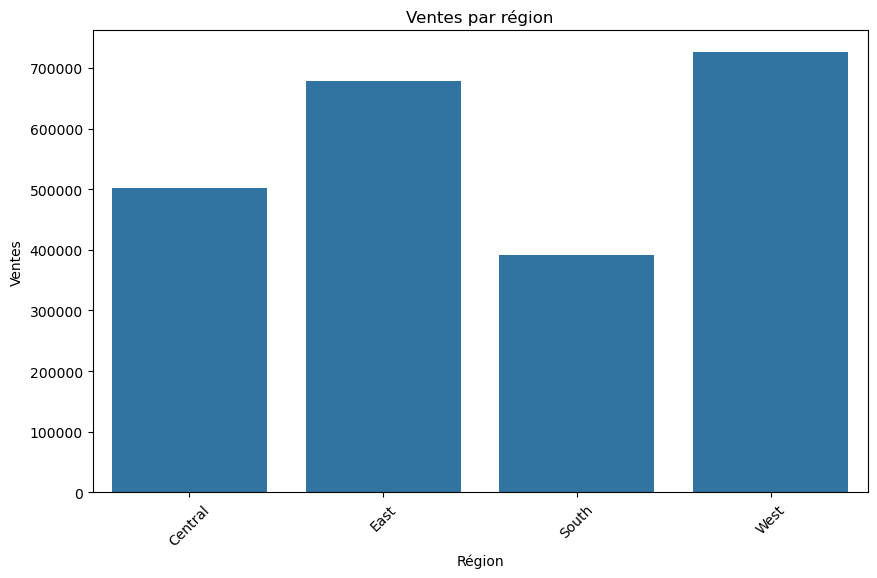

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_region, x='region', y='sales')
plt.title('Ventes par région')
plt.xlabel('Région')
plt.ylabel('Ventes')
plt.xticks(rotation=45)
plt.show()

2. Visualisation des catégories de clients

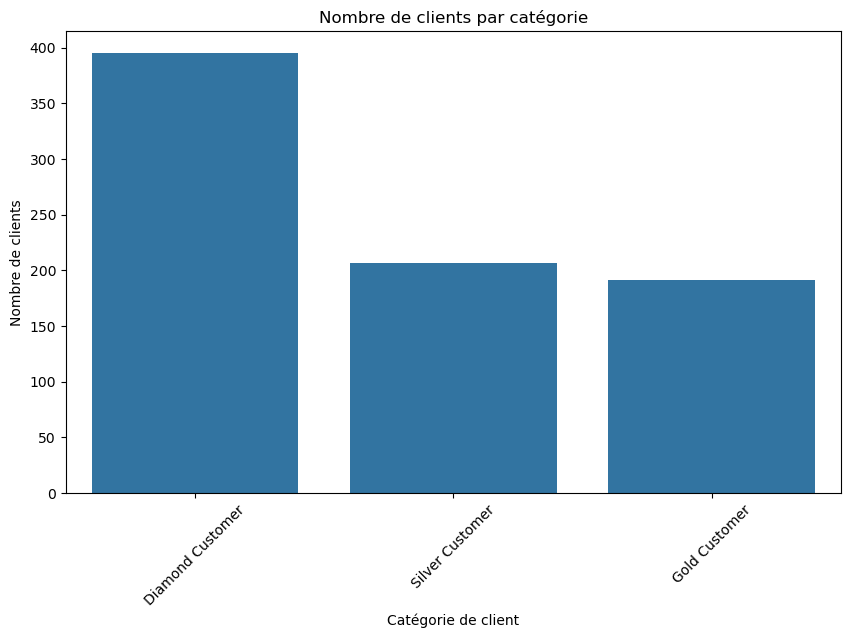

In [17]:
# Compte des clients par catégorie
customer_category_counts = sales_by_customer_category['customer_category'].value_counts().reset_index()

# Configuration de la visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=customer_category_counts, x='customer_category', y='count')
plt.title('Nombre de clients par catégorie')
plt.xlabel('Catégorie de client')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.show()